# SIRI-WHU 遥感场景分类 (PyTorch Lightning + timm)

本 Notebook 使用 PyTorch Lightning 和 timm 库，针对 SIRI-WHU 遥感数据集进行场景分类。
支持 ResNet、GoogleNet、ViT 等多种骨干网络，并包含完整的数据处理、训练流程及结果可视化。

## 1. 环境配置与库导入
安装并导入必要的库。如果尚未安装，请取消注释并运行安装命令。

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, datasets

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

import timm

# 设置随机种子
def seed_everything(seed=42):
    pl.seed_everything(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

# 指定使用的 GPU 序号，例如 [0] 或 [0, 1]
# 请根据实际情况修改此列表
DEVICES = [0]

Seed set to 42


## 2. SIRI-WHU 数据集加载与预处理

定义数据转换，加载数据集，并划分为训练集、验证集和测试集。
SIRI-WHU 数据集包含 12 个类别，每个类别 200 张图片。
我们将图片 Resize 到 224x224 以适配大多数预训练模型（如 ViT, ResNet）。

In [2]:
# 数据集路径
DATA_DIR = 'SIRI-WHU'
BATCH_SIZE = 32
NUM_WORKERS = 0 # Windows下建议设为0，Linux可设为4或8

# 定义数据增强和预处理
# 训练集：增加随机翻转等增强
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 验证/测试集：仅 Resize 和 Normalize
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载完整数据集
full_dataset = datasets.ImageFolder(root=DATA_DIR)
# class_names = full_dataset.classes
class_names = ['agriculture', 'commercial', 'harbor', 'idle_land', 'industrial', 
               'meadow', 'overpass', 'park', 'pond', 'residential', 'river', 'water']
print(f"Classes: {class_names}")

# 划分数据集 (例如 60% 训练, 20% 验证, 20% 测试)
total_size = len(full_dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

# 应用不同的 Transform
# 注意：random_split 后的子集直接继承父集的 transform，这里我们需要手动包装一下以应用不同的 transform
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_dataset = TransformedSubset(train_dataset, transform=train_transforms)
val_dataset = TransformedSubset(val_dataset, transform=val_test_transforms)
test_dataset = TransformedSubset(test_dataset, transform=val_test_transforms)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Classes: ['agriculture', 'commercial', 'harbor', 'idle_land', 'industrial', 'meadow', 'overpass', 'park', 'pond', 'residential', 'river', 'water']
Train size: 1440, Val size: 480, Test size: 480


## 3. 数据可视化与探索

检查一个 Batch 的数据，确保加载正确。

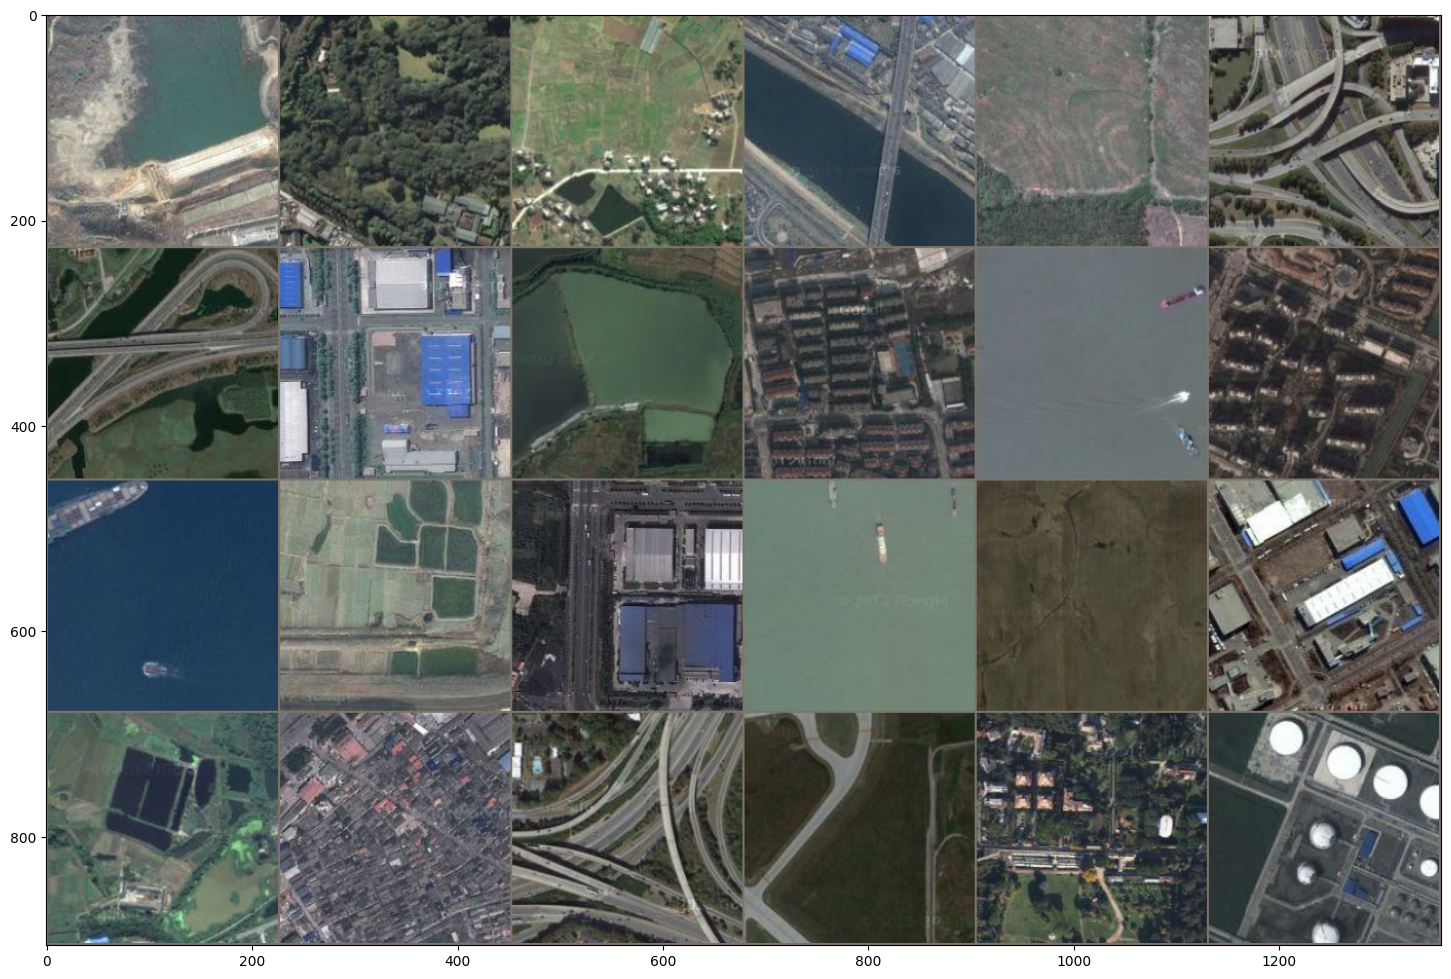

In [72]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# 获取一个 batch 的训练数据
inputs, classes = next(iter(train_loader))

# 制作网格
show_num = 24
out = torchvision.utils.make_grid(inputs[:show_num], nrow=6) # 展示前show_num张

plt.figure(figsize=(18, 15))
imshow(out, title=None and [class_names[x] for x in classes[:show_num]])

## 4. 定义 PyTorch Lightning 模块

使用 `timm` 创建骨干网络，并封装在 `LightningModule` 中。
支持模型名称作为参数传入，例如 `resnet50`, `vit_base_patch16_224`, `googlenet` (inception_v3) 等。

In [4]:
class SceneClassifier(pl.LightningModule):
    def __init__(self, model_name='resnet50', num_classes=12, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        # 使用 timm 创建模型，pretrained=True 使用 ImageNet 预训练权重
        self.model = timm.create_model(
            model_name, pretrained=True, num_classes=num_classes)

        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # 计算准确率
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()

        self.log('train_loss', loss, on_step=True,
                 on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()

        self.log('test_loss', loss, on_epoch=True)
        self.log('test_acc', acc, on_epoch=True)
        return {'loss': loss, 'preds': preds, 'targets': y}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        logits = self(x)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        return {'probs': probs, 'preds': preds, 'targets': y, 'inputs': x}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=5, gamma=0.5)
        return [optimizer], [scheduler]

## 5. 模型训练配置与回调函数

配置 Trainer，设置 Checkpoint 保存最佳模型，设置 EarlyStopping 防止过拟合。
你可以修改 `MODEL_NAME` 来切换不同的骨干网络，例如：
- `resnet50`
- `vit_base_patch16_224`
- `googlenet`
- `densenet121`
- `efficientnet_b0`

In [47]:
timm.list_models(filter='**')  # 列出所有可用的预训练模型

['aimv2_1b_patch14_224',
 'aimv2_1b_patch14_336',
 'aimv2_1b_patch14_448',
 'aimv2_3b_patch14_224',
 'aimv2_3b_patch14_336',
 'aimv2_3b_patch14_448',
 'aimv2_huge_patch14_224',
 'aimv2_huge_patch14_336',
 'aimv2_huge_patch14_448',
 'aimv2_large_patch14_224',
 'aimv2_large_patch14_336',
 'aimv2_large_patch14_448',
 'bat_resnext26ts',
 'beit3_base_patch16_224',
 'beit3_giant_patch14_224',
 'beit3_giant_patch14_336',
 'beit3_large_patch16_224',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_sma

In [59]:
# 模型名称
# MODEL_NAME = 'resnet50'
# MODEL_NAME = 'inception_v3'
# MODEL_NAME = 'convnext_base'
MODEL_NAME = 'mambaout_base'
# MODEL_NAME = 'vit_base_patch16_224'
# MODEL_NAME = 'swin_base_patch4_window7_224'
MAX_EPOCHS = 20
LEARNING_RATE = 1e-4

# 回调函数
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath='checkpoints',
    filename=f'{MODEL_NAME}-{{epoch:02d}}-{{val_acc:.2f}}',
    save_top_k=1,
    mode='max',
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=True,
    mode='min'
)

# Logger
logger = TensorBoardLogger("lightning_logs", name=MODEL_NAME)

# 实例化模型
model = SceneClassifier(model_name=MODEL_NAME, num_classes=len(class_names), lr=LEARNING_RATE)

# 实例化 Trainer
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator='gpu',
    devices=DEVICES,
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=logger,
    log_every_n_steps=10
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [60]:
# Model Summary
from pytorch_lightning.utilities.model_summary import summarize
print(summarize(model, max_depth=2))

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | MambaOut         | 81.8 M | train
1 | model.stem   | Stem             | 76.0 K | train
2 | model.stages | Sequential       | 79.3 M | train
3 | model.head   | MlpHead          | 2.4 M  | train
4 | criterion    | CrossEntropyLoss | 0      | train
----------------------------------------------------------
81.8 M    Trainable params
0         Non-trainable params
81.8 M    Total params
327.108   Total estimated model params size (MB)
331       Modules in train mode
0         Modules in eval mode


In [61]:
model.model

MambaOut(
  (stem): Stem(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
    (act): GELU(approximate='none')
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (norm2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): MambaOutStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): GatedConvBlock(
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (fc1): Linear(in_features=128, out_features=682, bias=True)
          (act): GELU(approximate='none')
          (conv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (fc2): Linear(in_features=341, out_features=128, bias=True)
          (ls): Identity()
          (drop_path): Identity()
        )
        (1): GatedConvBlock(
          (norm): LayerNorm((128,), eps=1e-06, elementw

## 6. 模型训练与验证

开始训练模型。训练过程中会自动在验证集上进行评估。

In [62]:
# 开始训练
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MambaOut         | 81.8 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
81.8 M    Trainable params
0         Non-trainable params
81.8 M    Total params
327.108   Total estimated model params size (MB)
331       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.722


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 0.656


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.648


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.627


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.621


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.612


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.610


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.610


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.609


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.609


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


## 7. 训练过程可视化 (TensorBoard)

在 Notebook 中直接加载 TensorBoard 查看训练曲线。
如果无法显示，请在终端运行 `tensorboard --logdir lightning_logs` 并在浏览器访问。

## 8. 模型评估与混淆矩阵可视化

加载最佳模型权重，在测试集上进行评估，并绘制混淆矩阵。

Best model path: /home/zzy/project/SIRI-WHU-Classification/checkpoints/vit_base_patch16_224-epoch=09-val_acc=0.98.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/zzy/miniconda3/envs/torch25/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=191` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

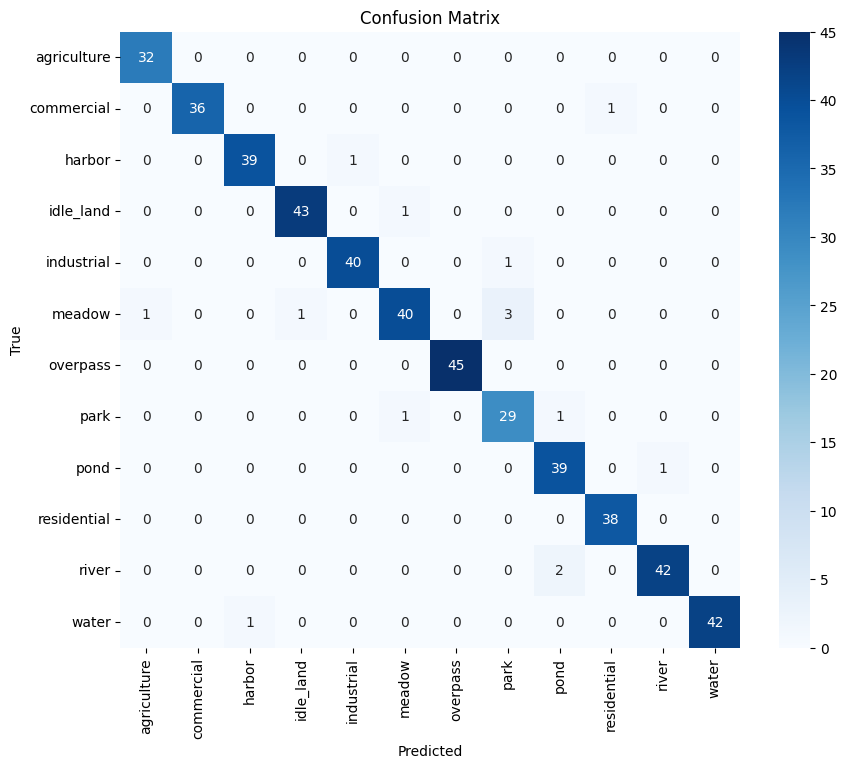

              precision    recall  f1-score   support

 agriculture       0.97      1.00      0.98        32
  commercial       1.00      0.97      0.99        37
      harbor       0.97      0.97      0.97        40
   idle_land       0.98      0.98      0.98        44
  industrial       0.98      0.98      0.98        41
      meadow       0.95      0.89      0.92        45
    overpass       1.00      1.00      1.00        45
        park       0.88      0.94      0.91        31
        pond       0.93      0.97      0.95        40
 residential       0.97      1.00      0.99        38
       river       0.98      0.95      0.97        44
       water       1.00      0.98      0.99        43

    accuracy                           0.97       480
   macro avg       0.97      0.97      0.97       480
weighted avg       0.97      0.97      0.97       480



In [19]:
# 加载最佳模型
best_model_path = checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")

best_model = SceneClassifier.load_from_checkpoint(best_model_path)

# 使用 Trainer 进行预测
# trainer.predict 会自动处理设备和评估模式，避免手动管理 device 导致的内存泄漏
predictions = trainer.predict(best_model, dataloaders=test_loader)

# 处理预测结果
all_preds = []
all_targets = []

for batch in predictions:
    all_preds.extend(batch['preds'].cpu().numpy())
    all_targets.extend(batch['targets'].cpu().numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# 计算混淆矩阵
cm = confusion_matrix(all_targets, all_preds)

# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 打印分类报告
print(classification_report(all_targets, all_preds, target_names=class_names))

## 9. 预测结果展示

随机抽取测试集样本，展示预测结果。

Searching for a batch with misclassifications...
Found a batch with misclassifications after 1 attempts.


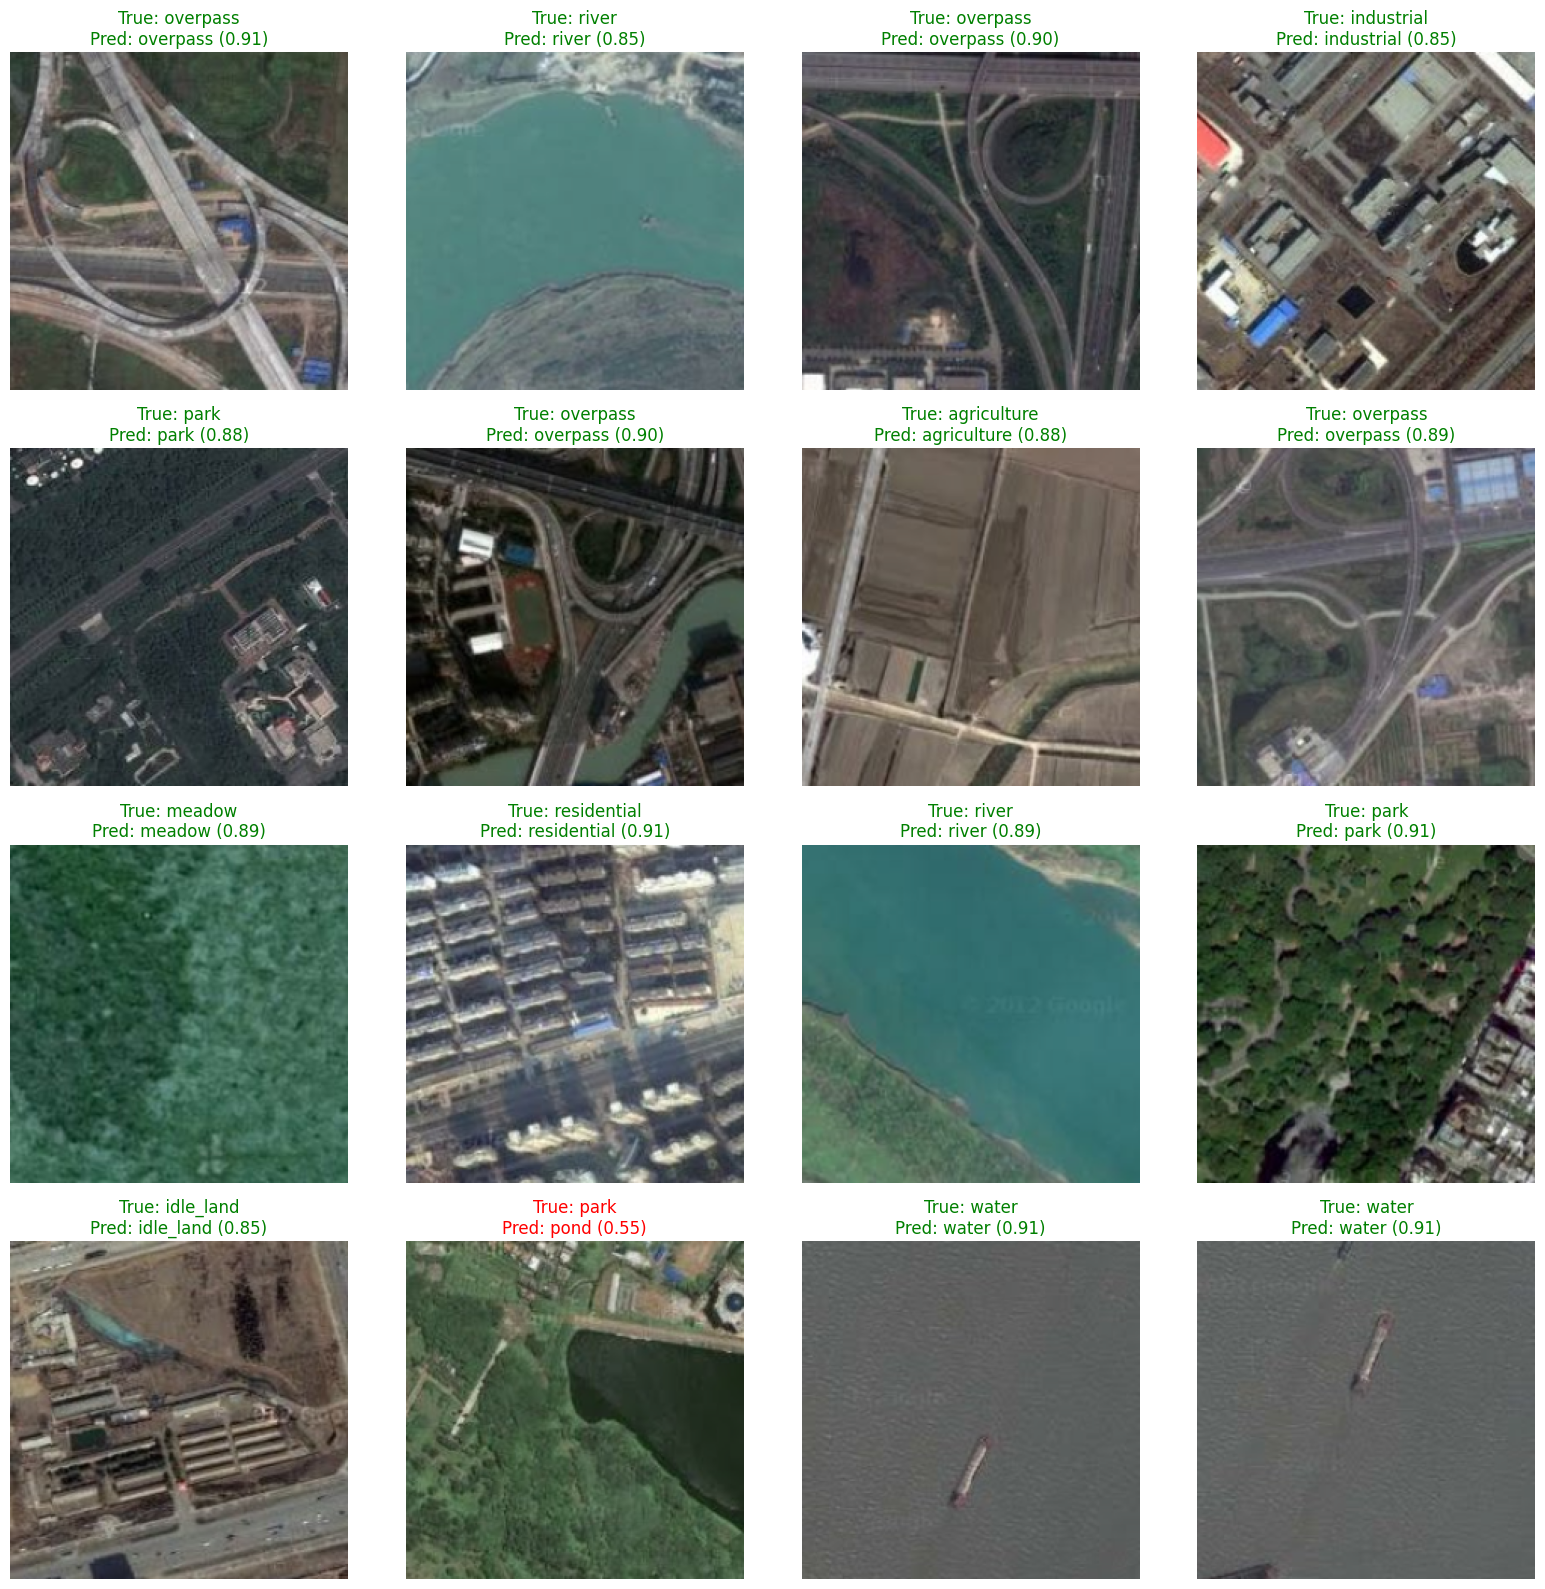

In [76]:
# 创建一个用于可视化的 DataLoader (随机抽取)
# 我们将不断抽取 batch，直到找到一个包含错误预测的 batch
found_error_batch = False
max_attempts = 20  # 最大尝试次数，防止死循环
attempt = 0

# 使用 shuffle=True 的 DataLoader 来随机获取 batch
vis_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=0)
vis_iterator = iter(vis_loader)

print("Searching for a batch with misclassifications...")

while not found_error_batch and attempt < max_attempts:
    try:
        batch = next(vis_iterator)
    except StopIteration:
        # 如果遍历完了一遍，重新开始
        vis_iterator = iter(vis_loader)
        batch = next(vis_iterator)
        
    attempt += 1
    
    # 使用 Trainer 预测当前 batch
    # trainer.predict 接受 dataloader 或 list of batches，这里我们包装成 list
    # 注意：为了效率，这里我们直接调用 best_model 进行推理，因为只处理一个 batch
    # 如果必须用 trainer，可以构造一个临时的 dataloader
    
    # 构造临时 DataLoader
    temp_loader = DataLoader([batch], batch_size=None, collate_fn=lambda x: x) # batch 已经是 collated 的 tensor tuple
    
    # 或者更简单地，直接用 best_model (注意 device)
    # 为了保持一致性，我们还是用 trainer.predict，传入一个只包含当前 batch 的 loader
    # 但 trainer.predict 期望的是 dataset 或 dataloader。
    # 让我们直接用 best_model 进行快速检查，找到错误后再用 trainer 走一遍流程或者直接用结果
    
    inputs, targets = batch
    inputs = inputs.to(best_model.device)
    targets = targets.to(best_model.device)
    
    best_model.eval()
    with torch.no_grad():
        logits = best_model(inputs)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        
    # 检查是否有错误
    if (preds != targets).any():
        found_error_batch = True
        print(f"Found a batch with misclassifications after {attempt} attempts.")
        
        # 准备可视化数据
        inputs = inputs.cpu()
        preds = preds.cpu()
        targets = targets.cpu()
        probs = probs.cpu()
        
        # 展示前 16 张 (或者 batch size)
        plt.figure(figsize=(16, 16))
        for i in range(len(inputs)):
            if i >= 16:
                break
            ax = plt.subplot(4, 4, i + 1)
            
            img = inputs[i].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            
            plt.imshow(img)
            
            true_label = class_names[targets[i]]
            pred_label = class_names[preds[i]]
            confidence = probs[i][preds[i]].item()
            
            color = 'green' if true_label == pred_label else 'red'
            
            plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.2f})", color=color)
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        break

if not found_error_batch:
    print(f"No misclassifications found after checking {max_attempts} batches.")